In [16]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [17]:
import sys, os
sys.path.append(os.pardir)
#from common.util import im2col
import numpy as np

x1 = np.random.rand(1, 3, 7, 7)  # batch_size, channel_size, height, width
coll = im2col(x1, 5, 5, stride=1, pad=0)
print(coll.shape)

x2 = np.random.rand(10, 3, 7, 7)  # batch_size, channel_size, height, width
coll = im2col(x2, 5, 5, stride=1, pad=0)
print(coll.shape)


(9, 75)
(90, 75)


In [5]:
class Convolution:
    
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T  
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)  #?
        
        return out

In [7]:
class Pooling:

    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (H - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad) #?
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) 
        
        return out 

In [22]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]            
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.30022606535
=== epoch:1, train acc:0.233, test acc:0.223 ===
train loss:2.29939960027
train loss:2.29518729673
train loss:2.28901755095
train loss:2.28401148956
train loss:2.2736991712
train loss:2.25535804877
train loss:2.24867227311
train loss:2.22967144857
train loss:2.19619425257
train loss:2.20343527963
train loss:2.13860469709
train loss:2.10578110039
train loss:2.05440647813
train loss:2.01609557897
train loss:1.96961235878
train loss:1.89920095091
train loss:1.82397684957
train loss:1.77226185804
train loss:1.71560318626
train loss:1.56903123155
train loss:1.56055646908
train loss:1.4178563478
train loss:1.41959241141
train loss:1.25414716698
train loss:1.31435785899
train loss:1.17781131257
train loss:1.06830175049
train loss:1.02586807376
train loss:0.925791556847
train loss:0.796584524533
train loss:0.651982516349
train loss:0.800595639673
train loss:0.660801734357
train loss:0.723120867688
train loss:0.71272365228
train loss:0.527912729159
train loss:0.75631101

train loss:0.191296929569
train loss:0.295282104981
train loss:0.209872904586
train loss:0.191763128053
train loss:0.15700236896
train loss:0.176147450559
train loss:0.330009939541
train loss:0.2103688827
train loss:0.161217846957
train loss:0.229261259993
train loss:0.182834336127
train loss:0.209428137205
train loss:0.214959345191
train loss:0.191248715112
train loss:0.177145898637
train loss:0.199832671284
train loss:0.130380999931
train loss:0.147767705275
train loss:0.183753234632
train loss:0.285270625068
train loss:0.218649323463
train loss:0.0956122653784
train loss:0.329575538034
train loss:0.258642068043
train loss:0.088095762121
train loss:0.155145220734
train loss:0.258811649672
train loss:0.142258777975
train loss:0.170925292729
train loss:0.148148422602
train loss:0.182845814089
train loss:0.23996304932
train loss:0.26395463165
train loss:0.0790001956186
train loss:0.0843713538818
train loss:0.113387571144
train loss:0.142691209818
train loss:0.088336505748
train loss:0.1

train loss:0.0642272261165
train loss:0.0658663492071
train loss:0.0835582863268
train loss:0.0561899897386
train loss:0.0776791892761
train loss:0.0938779982774
train loss:0.136202647334
train loss:0.0608956774945
train loss:0.111180521486
train loss:0.135631608664
train loss:0.0433381814821
train loss:0.0378916241159
train loss:0.177992420223
train loss:0.13115419262
train loss:0.0331836583585
train loss:0.068482632552
train loss:0.184078603763
train loss:0.195856731846
train loss:0.109064783832
train loss:0.151460146425
train loss:0.0771008240149
train loss:0.0432840427513
train loss:0.0895077823285
train loss:0.119295973543
train loss:0.0554319679783
train loss:0.107696820335
train loss:0.090546560789
train loss:0.0714192112339
train loss:0.134975966321
train loss:0.0371736702494
train loss:0.0993704240586
train loss:0.105112354408
train loss:0.0684604349434
train loss:0.0603047032183
train loss:0.0957707388666
train loss:0.0727634249781
train loss:0.0818024088964
train loss:0.0705

train loss:0.0548549446636
train loss:0.0410716221878
train loss:0.0734490585743
train loss:0.108126165646
train loss:0.054153697586
train loss:0.109167901003
train loss:0.102067386447
train loss:0.0653992432738
train loss:0.0529272260444
train loss:0.146021857716
train loss:0.0584628906296
train loss:0.137915014557
train loss:0.0563688156788
train loss:0.0268585703307
train loss:0.0382960806962
train loss:0.0398152599098
train loss:0.0572790534878
train loss:0.0941394328598
train loss:0.0264503602162
train loss:0.0888701167235
train loss:0.0671687544133
train loss:0.0962112121665
train loss:0.0946643212992
train loss:0.0315960793191
train loss:0.0696253142673
train loss:0.0520464538591
train loss:0.0553067145907
train loss:0.0471375680341
train loss:0.024366084197
train loss:0.143714428123
train loss:0.0474405299991
train loss:0.0430672742677
train loss:0.0276810077962
train loss:0.0560115813726
train loss:0.12808406309
train loss:0.10335570885
train loss:0.0776982728523
train loss:0.

train loss:0.0258560623308
train loss:0.0285947820509
train loss:0.0801149264963
train loss:0.0345706856073
train loss:0.119479998319
train loss:0.0221908149581
train loss:0.0523206680118
train loss:0.0487670618694
train loss:0.0754175279895
train loss:0.07792915902
train loss:0.0158086814157
train loss:0.0754575575633
train loss:0.0498035234045
train loss:0.0217712793374
train loss:0.0677285974984
train loss:0.0609712202332
train loss:0.101617541149
train loss:0.065036216974
train loss:0.0297087766885
train loss:0.0268966707964
train loss:0.061643586022
train loss:0.0988297117913
train loss:0.0728456869566
train loss:0.0792026799921
train loss:0.0877669056433
train loss:0.0413029062157
train loss:0.0374881807898
train loss:0.103662264883
train loss:0.0297358603749
train loss:0.0343519123137
train loss:0.0758303141548
train loss:0.0457551699675
train loss:0.0261487684322
train loss:0.0294673572955
train loss:0.186791493535
train loss:0.0442938825296
train loss:0.0338483543856
train los

train loss:0.0107166065985
train loss:0.054481885407
train loss:0.0849038263326
train loss:0.0144629521081
train loss:0.0245449051786
train loss:0.0911851497841
train loss:0.0589382982115
train loss:0.0297970605307
train loss:0.0465613681904
train loss:0.0573442982174
train loss:0.065437878811
train loss:0.031138828339
train loss:0.0361074422701
train loss:0.0386756248953
train loss:0.0860151389659
train loss:0.0241561137872
train loss:0.0270930233013
train loss:0.0575136667332
train loss:0.0292559526224
train loss:0.0784275013196
train loss:0.0682547575076
train loss:0.0244211056333
train loss:0.0362103140121
train loss:0.0338743658278
train loss:0.0423030118904
train loss:0.0229930479447
train loss:0.0234278551584
train loss:0.00613629943135
train loss:0.0687931568562
train loss:0.0687037309416
train loss:0.037245705437
train loss:0.0272668779845
train loss:0.0269669652225
train loss:0.0303513281221
train loss:0.0049338846663
train loss:0.0795210960686
train loss:0.0474078070201
trai

train loss:0.0230986516623
train loss:0.00767744849497
train loss:0.00895235369839
train loss:0.105853903199
train loss:0.0959464068852
train loss:0.0826456420033
train loss:0.0185350923801
train loss:0.0270846463811
train loss:0.0453660971412
train loss:0.0587664197315
train loss:0.0952071385717
train loss:0.00828667366055
train loss:0.0215406408689
train loss:0.027532360264
train loss:0.0234285365961
train loss:0.0286186477046
train loss:0.0344974454411
train loss:0.0364553768359
train loss:0.0421619291999
train loss:0.0347986366227
train loss:0.0767674557033
train loss:0.0333659199667
train loss:0.0140915839353
train loss:0.0234878775456
train loss:0.0135875986508
train loss:0.0139315000329
train loss:0.0147251481328
train loss:0.0912934181928
train loss:0.0476118701328
train loss:0.00769619786845
train loss:0.0913227470621
train loss:0.0553435805687
train loss:0.0132412897151
train loss:0.00516785732707
train loss:0.0477247617126
train loss:0.0265110286392
train loss:0.030922990149

train loss:0.0438304274112
train loss:0.0145499080387
train loss:0.0119808818209
train loss:0.0169825506328
train loss:0.00680921546327
train loss:0.0162602555271
train loss:0.0457859614795
train loss:0.00793969830243
train loss:0.00963579900085
train loss:0.00401431039547
train loss:0.026772463428
train loss:0.0116961306302
train loss:0.0873310692798
train loss:0.0754622649812
train loss:0.0546190692753
train loss:0.00381312486296
train loss:0.0247456787806
train loss:0.0230527002923
train loss:0.042889243643
train loss:0.0670535435607
train loss:0.128591088219
train loss:0.0239631054046
train loss:0.0116135985475
train loss:0.0252339067247
train loss:0.050105075889
train loss:0.0176244344659
train loss:0.0232507149493
train loss:0.0210828276431
train loss:0.0239219122882
train loss:0.022085948405
train loss:0.0247946079607
train loss:0.0313151340568
train loss:0.0513651154867
train loss:0.0334538881482
train loss:0.0152479430155
train loss:0.00856546700717
train loss:0.0164455196272


train loss:0.0313266343336
train loss:0.0117498017445
train loss:0.026955608387
train loss:0.0319090620687
train loss:0.0316404986759
train loss:0.0430642636137
train loss:0.0215149307882
train loss:0.00437188564038
train loss:0.106842767205
train loss:0.0382896083287
train loss:0.0103833743601
train loss:0.0424389161207
train loss:0.026685600997
train loss:0.0126970603564
train loss:0.0140923130275
train loss:0.0476570881002
train loss:0.00671375838449
train loss:0.0573207549407
train loss:0.00893437193626
train loss:0.0334662091495
train loss:0.00925202403646
train loss:0.0139817881772
train loss:0.00881347176048
train loss:0.010682938235
train loss:0.0309588255131
train loss:0.0458179980527
train loss:0.0224549403456
train loss:0.00795913613523
train loss:0.0411263594756
train loss:0.040864833182
train loss:0.0147118038753
train loss:0.0106733601008
train loss:0.00697649540987
train loss:0.00659631609554
train loss:0.0111739921133
train loss:0.00929265419424
train loss:0.09609859435

train loss:0.00898681121313
train loss:0.00909778048984
train loss:0.0259441130944
train loss:0.00309392710566
train loss:0.0208993621301
train loss:0.061059389123
train loss:0.0172261745583
train loss:0.0590770234733
train loss:0.0543623015391
train loss:0.00627677485883
train loss:0.0135860041737
train loss:0.0245098788959
train loss:0.0391443231448
train loss:0.0127468077145
train loss:0.0115497580982
train loss:0.0210192250415
train loss:0.0132925192407
train loss:0.013803330535
train loss:0.0145948357374
train loss:0.0132177575697
train loss:0.0130590682064
train loss:0.0255584194569
train loss:0.00760050186862
train loss:0.0184200433137
train loss:0.0204954472975
train loss:0.00565588756297
train loss:0.0216848595223
train loss:0.0103355370389
train loss:0.0368080389582
train loss:0.00866026906962
train loss:0.030441818253
train loss:0.0650512182198
train loss:0.0271779245011
train loss:0.0395898008601
train loss:0.00330780058724
train loss:0.0278831586578
train loss:0.0098949876

train loss:0.0277198329629
train loss:0.0020888596635
train loss:0.0421952177373
train loss:0.0193344530551
train loss:0.010029485357
train loss:0.0139166062304
train loss:0.00722901291756
train loss:0.0086703228875
train loss:0.00948826658275
train loss:0.00107194644541
train loss:0.0121255385266
train loss:0.0591574979473
train loss:0.0481028189921
train loss:0.00622779748999
train loss:0.00317849507451
train loss:0.00385027478354
train loss:0.0089488889886
train loss:0.00302872751145
train loss:0.0121330110648
train loss:0.0460145699979
train loss:0.0234266439283
train loss:0.0243870743131
train loss:0.027117683137
train loss:0.0085244172728
train loss:0.00885474157766
train loss:0.0284210802397
train loss:0.00863417893019
train loss:0.014261870881
train loss:0.0118768528604
train loss:0.00685908864238
train loss:0.00822688815396
train loss:0.0316346180443
train loss:0.0106562173377
train loss:0.00541636332961
train loss:0.0816129705752
train loss:0.0295224024083
train loss:0.011057

train loss:0.0575174509188
train loss:0.00907074273745
train loss:0.021499152751
train loss:0.0343205450995
train loss:0.0363943566209
train loss:0.00305144965772
train loss:0.0120408835108
train loss:0.0160473084434
train loss:0.00296665898212
train loss:0.00950910095119
train loss:0.00497691444777
train loss:0.00660796664473
train loss:0.0259085881158
train loss:0.0100498789694
train loss:0.00808321605588
train loss:0.0179045595865
train loss:0.0148573955545
train loss:0.0171261174723
train loss:0.0259441361894
train loss:0.00351869779808
train loss:0.00600456897242
train loss:0.0390602567355
train loss:0.0294377406225
train loss:0.0173004786899
train loss:0.0107988812116
train loss:0.00879220974265
train loss:0.0223991963109
train loss:0.169062318584
train loss:0.0149592247288
train loss:0.0335792350664
train loss:0.0194753174144
train loss:0.0116058483557
train loss:0.0372575155665
train loss:0.0138636381281
train loss:0.00748677222756
train loss:0.016845151301
train loss:0.0045152

train loss:0.00409402318313
train loss:0.0196990718507
train loss:0.0225986294529
train loss:0.00995013219308
train loss:0.0733800482905
train loss:0.00385105231565
train loss:0.00601838022954
train loss:0.00918978486959
train loss:0.0194483549153
train loss:0.00612576458497
train loss:0.00800413040215
train loss:0.00480817059676
train loss:0.00820868556988
train loss:0.0152864311663
train loss:0.00309621601194
train loss:0.00274023932508
train loss:0.01297353969
train loss:0.0103816707121
train loss:0.00584990072034
train loss:0.00957553399522
train loss:0.00646740841776
train loss:0.0121388093764
train loss:0.0162673322931
train loss:0.0172311909431
train loss:0.0380257901274
train loss:0.0401981077088
train loss:0.0424491901173
train loss:0.00440759378878
train loss:0.014020038435
train loss:0.0015369365072
train loss:0.0193582506148
train loss:0.00606738117106
train loss:0.00700970889043
train loss:0.00809572857516
train loss:0.0507589480625
train loss:0.0121328844161
train loss:0.

train loss:0.0219244979207
train loss:0.0174163607622
train loss:0.00412008808699
train loss:0.029583742355
train loss:0.00226846309745
train loss:0.0340555349824
train loss:0.00936967181463
train loss:0.00216733130993
train loss:0.0220946271275
train loss:0.0604040748262
train loss:0.00533633411015
train loss:0.0107151342113
train loss:0.0154768541989
train loss:0.0117339761333
train loss:0.00268191365894
train loss:0.00451007709291
train loss:0.00304085311016
train loss:0.0117389721461
train loss:0.0278301272975
train loss:0.00643366911443
train loss:0.0661374790952
train loss:0.0286929167691
train loss:0.00317627223611
train loss:0.00338424128837
train loss:0.0112474330919
train loss:0.0206048467871
train loss:0.0316265804902
train loss:0.00422397170955
train loss:0.0380170441388
train loss:0.00775342470464
train loss:0.00192499826754
train loss:0.0049819246104
train loss:0.00323268804025
train loss:0.00203120423875
train loss:0.00532544117876
train loss:0.0115984359786
train loss:0

train loss:0.0220105636657
train loss:0.0106136599516
train loss:0.00239286904545
train loss:0.0139548392387
train loss:0.00485957268848
train loss:0.00104293777185
train loss:0.020934771871
train loss:0.0198316390735
train loss:0.00622959884723
train loss:0.00780611763517
train loss:0.00215406245069
train loss:0.0107623339056
train loss:0.00417123755959
train loss:0.00396755134868
train loss:0.00254811596386
train loss:0.00379777731879
train loss:0.00161474614426
train loss:0.00165679734267
train loss:0.0133698309717
train loss:0.00755718410902
train loss:0.0394213841922
train loss:0.168892772898
train loss:0.00895723714739
train loss:0.00440499819759
train loss:0.00626831590125
train loss:0.00423156601796
train loss:0.00630321859025
train loss:0.000426968914465
train loss:0.00593269899354
train loss:0.00643028103267
train loss:0.0176025240595
train loss:0.00810156267397
train loss:0.0058114108812
train loss:0.0308702922467
train loss:0.00701437007664
train loss:0.0182158189191
train 

train loss:0.0120222590888
train loss:0.00955404834241
train loss:0.00977179503632
train loss:0.0088176344207
train loss:0.0108395418638
train loss:0.00713504067652
train loss:0.0161280833977
train loss:0.00543284037402
train loss:0.0256282288276
train loss:0.0095441655128
train loss:0.00568481974707
train loss:0.00231062744646
train loss:0.00318452833873
train loss:0.00336519717278
train loss:0.0285460299405
train loss:0.00206973424039
train loss:0.00517818119659
train loss:0.00782455233585
train loss:0.00141925196789
train loss:0.0120341861484
train loss:0.00925762758547
train loss:0.00630754629464
train loss:0.00453564622167
train loss:0.00185196422621
train loss:0.00360473999124
train loss:0.00695923241193
train loss:0.00181055388766
train loss:0.0136141872909
train loss:0.00343830538197
train loss:0.00419501229953
train loss:0.0130665504206
train loss:0.0376992660317
train loss:0.00792520475998
train loss:0.0382800763885
train loss:0.00882802928839
train loss:0.00292813861762
trai

train loss:0.0602332564781
train loss:0.0124561403652
train loss:0.00814273495654
train loss:0.00782531051511
train loss:0.00774706993662
train loss:0.0028647790958
train loss:0.00619404213015
train loss:0.0262468445448
train loss:0.0435738818926
train loss:0.00114963936684
train loss:0.000617007548544
train loss:0.0152536185126
train loss:0.005356772254
train loss:0.0568951867264
train loss:0.00892631410279
train loss:0.00609160224556
train loss:0.00340715159739
train loss:0.0209398434297
train loss:0.0113677482486
train loss:0.0067636182097
train loss:0.00962558691762
train loss:0.00468044137403
train loss:0.00128611630657
train loss:0.00586107219058
train loss:0.00610508330035
train loss:0.00557606465251
train loss:0.0304237418893
train loss:0.0353084591737
train loss:0.0034678336775
train loss:0.00612864552772
train loss:0.0253213048236
train loss:0.00284556516675
train loss:0.0177471214909
train loss:0.0106362215866
train loss:0.00193627266491
train loss:0.000756991369631
train lo

train loss:0.00214625989661
train loss:0.00343814686368
train loss:0.00762202256818
train loss:0.00417104397365
train loss:0.00566327780274
train loss:0.0657233618262
train loss:0.00302575496017
train loss:0.0468252364089
train loss:0.00837540588775
train loss:0.00310306406805
train loss:0.00744014188139
train loss:0.00498262122052
train loss:0.0138329973373
train loss:0.00906558638946
train loss:0.0230130139068
train loss:0.00638612015676
train loss:0.0048556083621
train loss:0.00496488602758
train loss:0.00922185944948
train loss:0.0174671220419
train loss:0.00524081617226
train loss:0.00334348216713
train loss:0.00632103222508
train loss:0.00552471209665
train loss:0.00511349366987
train loss:0.00536000268515
train loss:0.00361769503383
train loss:0.0242539157915
train loss:0.00808837469796
train loss:0.0150979829617
train loss:0.00187368775903
train loss:0.020940176818
train loss:0.013627584368
train loss:0.00192436791233
train loss:0.00438224784166
train loss:0.00437364503761
trai

train loss:0.0322586915492
train loss:0.00665547981766
train loss:0.0799955116908
train loss:0.0140345790773
train loss:0.009782199736
train loss:0.0398063738595
train loss:0.00681695576559
train loss:0.002972124733
train loss:0.0115992280606
train loss:0.0232850284591
train loss:0.00179058073964
train loss:0.0114907685777
train loss:0.00226797067133
train loss:0.00332215936558
train loss:0.00687916737996
train loss:0.0294147519199
train loss:0.0155358400766
train loss:0.0171733755608
train loss:0.0119250815369
train loss:0.000407471828735
train loss:0.00467690935202
train loss:0.0146064738599
train loss:0.00622331054595
train loss:0.00197476229511
train loss:0.00844031453124
train loss:0.0369113151529
train loss:0.00197683712882
train loss:0.0088314970851
train loss:0.0335264775064
train loss:0.00430805465037
train loss:0.00899430743759
train loss:0.00860803746876
train loss:0.00207669648031
train loss:0.0101896991048
train loss:0.00124611222664
train loss:0.00314552415814
train loss:

train loss:0.0051935521737
train loss:0.00276780537611
train loss:0.00206468991275
train loss:0.00539041550186
train loss:0.00632312541337
train loss:0.0469009052003
train loss:0.0102049112346
train loss:0.00230918298895
train loss:0.00325972275462
train loss:0.000750487405939
train loss:0.0248490248227
train loss:0.0100141566427
train loss:0.00282305887564
train loss:0.000995427398957
train loss:0.0155310703947
train loss:0.00379237120563
train loss:0.00579597640038
train loss:0.0169106871326
train loss:0.00167369933199
train loss:0.00161177284152
train loss:0.00113286570702
train loss:0.02119878421
train loss:0.0071991373961
train loss:0.00979862673416
train loss:0.0082548402915
train loss:0.00476525021214
train loss:0.00182990036088
train loss:0.00296196507415
train loss:0.00111595968394
train loss:0.00364995407041
train loss:0.00355336604551
train loss:0.00847698324807
train loss:0.0138778001696
train loss:0.00150867096665
train loss:0.00527192743038
train loss:0.00334395879875
tra

train loss:0.00320382897703
train loss:0.00321039224014
train loss:0.0213722594129
train loss:0.0170135235988
train loss:0.00631147060785
train loss:0.00356998324297
train loss:0.0125624047122
train loss:0.022927447752
train loss:0.00251792597916
train loss:0.00259214085197
train loss:0.00102855807981
train loss:0.00311758921448
train loss:0.000892088726613
train loss:0.0050629835687
train loss:0.00235514422364
train loss:0.000556473065245
train loss:0.00799642327055
train loss:0.00157443719182
train loss:0.00826147999748
train loss:0.00331002610202
train loss:0.00171260357149
train loss:0.0080945777197
train loss:0.00272263057493
train loss:0.00360791941107
train loss:0.00242853097195
train loss:0.0185639267971
train loss:0.00353373692179
train loss:0.0169319670157
train loss:0.00639452970516
train loss:0.0108170649573
train loss:0.0899819665358
train loss:0.00452912208551
train loss:0.00878248913653
train loss:0.0021238284576
train loss:0.00178455464211
train loss:0.017716487488
trai

train loss:0.00706199458765
train loss:0.0038210799491
train loss:0.000561905770728
train loss:0.018989817301
train loss:0.00134800202954
train loss:0.0018216746989
train loss:0.0168540156262
train loss:0.00162875906779
train loss:0.00108399318407
train loss:0.00698455105582
train loss:0.0074498374723
train loss:0.00432246086613
train loss:0.000973675363537
train loss:0.00374595556423
train loss:0.00141102047902
train loss:0.0177498968692
train loss:0.000436713277413
train loss:0.0146755731712
train loss:0.00354172785713
train loss:0.000779357652052
train loss:0.00149081847988
train loss:0.00236192777472
train loss:0.00435062165976
train loss:0.00221266131516
train loss:0.0165385689578
train loss:0.00290066700835
train loss:0.00892114064021
train loss:0.00260561689825
train loss:0.0207818785942
train loss:0.00053234401412
train loss:0.00915318779227
train loss:0.00674351839148
train loss:0.00915508598896
train loss:0.00537045295682
train loss:0.0103264730178
train loss:0.00147968711875

train loss:0.00398170629722
train loss:0.00199638555819
train loss:0.0179607069776
train loss:0.00578260776032
train loss:0.000497378195836
train loss:0.0146233964505
train loss:0.00216999741311
train loss:0.00058646535704
train loss:0.00372523481267
train loss:0.00446196532452
train loss:0.00603610583627
train loss:0.00112952681423
train loss:0.00113341159494
train loss:0.00572096120276
train loss:0.00328099981236
train loss:0.00340317987096
train loss:0.00616202991058
train loss:0.00185049059713
train loss:0.00776795349685
train loss:0.000594189802705
train loss:0.00155761030817
train loss:0.000639624199204
train loss:0.002445462531
train loss:0.0178400910981
train loss:0.000415934324772
train loss:0.00552039257243
train loss:0.000685929052307
train loss:0.00551874094268
train loss:0.00135926333935
train loss:0.0209492077441
train loss:0.00182084106439
train loss:0.00526429447965
train loss:0.000238394083069
train loss:0.00427267037581
train loss:0.00453860279687
train loss:0.0009120

train loss:0.00778662307161
train loss:0.00248779805056
train loss:0.000884948569959
train loss:0.00869914699802
train loss:0.000773293095837
train loss:0.00944250697627
train loss:0.0054379164023
train loss:0.00948322010718
train loss:0.00228579930251
train loss:0.00526602298383
train loss:0.00532054802356
train loss:0.00521767895879
train loss:0.00517008763894
train loss:0.00222333226206
train loss:0.012326773884
train loss:0.00645929003744
train loss:0.00247536452118
train loss:0.000834106404169
train loss:0.000807703220596
train loss:0.000962714553685
train loss:0.00294658529132
train loss:0.00791422408131
train loss:0.00553392861423
train loss:0.000989773288516
train loss:0.0099762363629
train loss:0.0209622796418
train loss:0.00510954195976
train loss:0.00379350801366
train loss:0.00491963415043
train loss:0.000462947985629
train loss:0.00228959819099
train loss:0.00600306413142
train loss:0.0022425965178
train loss:0.00720957476731
train loss:0.00483714590908
train loss:0.017438

train loss:0.00038475413836
train loss:0.00195618651016
train loss:0.00126705643817
train loss:0.0019570941293
train loss:0.00149229501446
train loss:0.00213543018507
train loss:0.000793957826905
train loss:0.0471820290817
train loss:0.00268584746589
train loss:0.0258735756441
train loss:0.00127479217891
train loss:0.00221865239209
train loss:0.0125351657952
train loss:0.00307382842126
train loss:0.0038803406368
train loss:0.00115079422995
train loss:0.00568506140208
train loss:0.00646910783132
train loss:0.00629681962686
train loss:0.00165449643653
train loss:0.00199256529822
train loss:0.00023032828888
train loss:0.00854780907393
train loss:0.00849404614496
train loss:0.000863068240407
train loss:0.00199576203642
train loss:0.00153886397823
train loss:0.00245511751453
train loss:0.00221754005381
train loss:0.000928231336339
train loss:0.0096664452921
train loss:0.000200349302932
train loss:0.000377436130867
train loss:0.0580064629246
train loss:0.00422082282033
train loss:0.003143164

train loss:0.00264646860367
train loss:0.000735900350452
train loss:0.00169781644803
train loss:0.00232349135574
train loss:0.0015631142149
train loss:0.000287343427676
train loss:0.0011565051114
train loss:0.00582364514316
train loss:0.00107561150468
train loss:0.000565449403659
train loss:0.00122893739609
train loss:0.00336605830901
train loss:0.000619272380564
train loss:0.00267660355852
train loss:0.0030606688339
train loss:0.000303895395555
train loss:0.0188416857864
train loss:0.000464036187124
train loss:0.0174867636247
train loss:0.000961040924161
train loss:0.000328933877622
train loss:0.000620266317262
train loss:0.00131409748306
train loss:0.00329233037493
train loss:0.000662192558852
train loss:0.00330020900223
train loss:0.000975069402271
train loss:0.00170224517544
train loss:0.00152979148604
train loss:0.00996801455285
train loss:0.000996374852017
train loss:0.00161048590555
train loss:0.000365760653459
train loss:0.00125900492477
train loss:0.00589936216547
train loss:0

train loss:0.0107253907039
train loss:0.00263414774822
train loss:0.00109475053408
train loss:0.000795977914619
train loss:0.000482057724118
train loss:0.00756304540002
train loss:0.000408207953042
=== epoch:14, train acc:0.998, test acc:0.987 ===
train loss:0.00395897343427
train loss:0.000967218820699
train loss:0.00326834017773
train loss:0.00844313808552
train loss:0.000651619598044
train loss:0.0022783908504
train loss:0.000398108386832
train loss:0.00019717752655
train loss:0.040604701716
train loss:0.0044582727212
train loss:0.00531259814468
train loss:0.000975913575448
train loss:0.000814864246453
train loss:0.00489232742448
train loss:0.00107452867402
train loss:0.00308416537505
train loss:0.000511402766683
train loss:0.00117574334687
train loss:0.00146933528365
train loss:0.00319301842202
train loss:0.000413803393196
train loss:0.00258235118588
train loss:0.00427266243072
train loss:0.0102411871449
train loss:0.00110090754251
train loss:0.000364517176545
train loss:0.00112433

train loss:0.00108453016935
train loss:0.00114574954608
train loss:0.000201301219625
train loss:0.00537908161788
train loss:4.24219371184e-05
train loss:0.000816884809923
train loss:0.00172816082351
train loss:0.000496899180512
train loss:0.0224009848866
train loss:0.00200631253668
train loss:0.00891602579799
train loss:8.8828386645e-05
train loss:0.00178558922507
train loss:0.00285979168821
train loss:0.00032078323126
train loss:0.00568097846438
train loss:0.00101723663758
train loss:0.00150546603776
train loss:0.000190660576388
train loss:0.0110841231081
train loss:0.00569407954037
train loss:0.000645442908916
train loss:0.00270131139279
train loss:0.00441486117756
train loss:0.0117014787967
train loss:0.00594817604335
train loss:0.00645871927211
train loss:0.00314881749953
train loss:0.00196491529192
train loss:0.00356759934433
train loss:0.00220495784638
train loss:0.00115934304573
train loss:0.000771973979414
train loss:0.0058547333998
train loss:0.000525715803699
train loss:0.000

train loss:0.00204006262147
train loss:0.00898555119377
train loss:0.0106455874506
train loss:0.00363488165148
train loss:0.00166451474133
train loss:0.000450273335342
train loss:0.00369179083698
train loss:0.00333528967452
train loss:0.000484646990412
train loss:0.00223117943633
train loss:0.000308707882034
train loss:0.0129504962816
train loss:0.00276648020117
train loss:0.000509651995013
train loss:0.000601550872834
train loss:0.0033681332861
train loss:0.000632229172036
train loss:0.00213984338235
train loss:0.00742570008631
train loss:6.86564169709e-05
train loss:0.000528657852666
train loss:0.00804035672397
train loss:0.0051046063536
train loss:0.000117634943058
=== epoch:15, train acc:0.998, test acc:0.986 ===
train loss:0.00103235266088
train loss:0.0007404627186
train loss:0.000332588793064
train loss:0.000208060509861
train loss:0.00183632612538
train loss:0.0164615157744
train loss:0.00285996187928
train loss:0.0045413672656
train loss:0.00453560467621
train loss:0.003027545

train loss:0.00529436299245
train loss:0.000316687586078
train loss:0.000158888645891
train loss:0.00355881615598
train loss:0.00712078468929
train loss:0.0136430942155
train loss:0.00258446947015
train loss:0.00962126933972
train loss:0.00617326617672
train loss:0.000425921036526
train loss:0.00362000714826
train loss:0.0080761800093
train loss:0.000911543057411
train loss:0.000356455395029
train loss:0.000440674578494
train loss:0.00832214942099
train loss:0.00236984725766
train loss:0.000290888046208
train loss:0.000995795316503
train loss:0.00163053435068
train loss:0.00379565063977
train loss:0.0195742372424
train loss:0.00354082441083
train loss:0.00533044090082
train loss:0.00057561534204
train loss:0.00345251896421
train loss:0.000790152349874
train loss:0.000530091786037
train loss:0.000770403436936
train loss:0.00650897297975
train loss:0.00364834260742
train loss:0.00372875540276
train loss:0.00312779654347
train loss:0.00138240375944
train loss:0.00169227950398
train loss:0

train loss:0.000329318937947
train loss:0.000598782613241
train loss:0.000962076099629
train loss:0.00100704634302
train loss:0.00206368436869
train loss:0.00257838475776
train loss:0.000160018984781
train loss:0.00241065952002
train loss:0.000818992078831
train loss:0.000530806844295
train loss:0.000544008883929
train loss:0.00139419216244
train loss:0.000213284165476
train loss:0.00512367461758
train loss:0.00550818231886
train loss:0.0066592448675
train loss:0.00271856661906
train loss:0.00216543237293
train loss:0.000503807730566
train loss:0.000648148250945
train loss:0.0111447815567
train loss:0.00285386294143
train loss:0.000880600840239
train loss:0.00229441436399
train loss:0.00169325174487
train loss:0.000298007083028
train loss:0.00051877788414
train loss:0.000121369120271
train loss:0.0338305717263
train loss:0.000563422529693
train loss:0.00232059565357
train loss:0.0123149353841
train loss:0.000446404892513
train loss:7.47655516286e-05
train loss:0.00288187145549
train lo

train loss:0.00257609204495
train loss:5.69765488964e-05
train loss:0.000361948379239
train loss:0.00451418105403
train loss:0.000182238932342
train loss:0.000687354318926
train loss:0.000314855334471
train loss:0.00157272005404
train loss:0.0015513512326
train loss:0.00327137819572
train loss:0.000449507625612
train loss:0.000680083014088
train loss:0.00284764055624
train loss:0.000836450765189
train loss:0.00269366503516
train loss:0.000403393032811
train loss:0.000109043034453
train loss:0.00342630158935
train loss:0.00336871108584
train loss:0.00141210543629
train loss:0.000819263709147
train loss:0.000556670946347
train loss:0.000378338300828
train loss:0.0010370012561
train loss:0.001950632492
train loss:0.00102874359279
train loss:0.00121884212429
train loss:0.00200046938667
train loss:0.0001574478818
train loss:0.00410233836473
train loss:0.0148080615035
train loss:0.000341859080233
train loss:0.00352032245769
train loss:0.00207510779576
train loss:0.00090508954917
train loss:0

train loss:0.000108627877699
train loss:0.0037521127453
train loss:0.00257323821272
train loss:0.00505696440312
train loss:0.00113780762957
train loss:0.000952221315031
train loss:0.00194107866109
train loss:9.70976645112e-05
train loss:0.00130919404811
train loss:0.00236373823998
train loss:0.000740658483443
train loss:0.000429275531134
train loss:0.00390345024303
train loss:0.00102660472938
train loss:0.00194999115606
train loss:0.000578723922814
train loss:0.000215912937548
train loss:0.0032411279535
train loss:0.0019294289941
train loss:0.00710891626993
train loss:0.00100196351323
train loss:0.00581258877028
train loss:0.00185249353248
train loss:0.00043665080664
train loss:0.000367943154318
train loss:0.000589697094923
train loss:2.99752240989e-05
train loss:0.000181079480536
train loss:0.0117531673752
train loss:0.000748791350485
train loss:0.000700596434796
train loss:0.000111053011192
train loss:0.0100679738266
train loss:0.00321851310447
train loss:0.00236393193551
train loss:

train loss:0.000214254424673
train loss:0.00389855066441
train loss:0.00455830627021
train loss:0.000166080242609
train loss:0.000304164507524
train loss:0.000365529913323
train loss:0.00294882698797
train loss:0.0013237213251
train loss:0.000322617398866
train loss:0.00215582063493
train loss:0.00886590760078
train loss:0.000723049474831
train loss:0.000254263518782
train loss:0.000134205068856
train loss:0.00110640777773
train loss:0.0184742069024
train loss:0.00063072634277
train loss:0.00384791422265
train loss:0.000391932328783
train loss:0.00238786197295
train loss:0.00141052605356
train loss:0.000310969682406
train loss:0.000665133437721
train loss:0.00164500198
train loss:6.30442159217e-05
train loss:0.000379952549641
train loss:0.00103571093379
train loss:0.000800305636424
train loss:0.00336077565577
train loss:0.00829704315705
train loss:0.00164625422415
train loss:0.00102323240748
train loss:0.00332133136057
train loss:0.000242197453432
train loss:0.00746014755163
train loss

train loss:0.000393261126034
train loss:0.00018244731059
train loss:0.00809867587924
train loss:0.000332136482331
train loss:0.00101514992566
train loss:0.00162311003656
train loss:0.00211023521
train loss:0.000291061282622
train loss:0.00058117737139
train loss:0.00262674000413
train loss:0.000459778495159
train loss:0.00100179164131
train loss:0.000850009324713
train loss:0.00089810567197
train loss:0.00222670922806
train loss:0.0012222492961
train loss:0.000211353497165
train loss:0.00641816591626
train loss:0.00245722373753
train loss:0.014844594928
train loss:0.000888822259974
train loss:0.000107897597989
train loss:0.000308665192603
train loss:0.00195272802999
train loss:0.000594981217629
train loss:0.00266078723649
train loss:9.60240114534e-05
train loss:0.000950626724034
train loss:0.000204922243118
train loss:0.00574104494423
train loss:0.000723468030372
train loss:0.00417703376231
train loss:0.00104132185832
train loss:9.74623672988e-05
train loss:0.000503011803174
train loss

train loss:0.000667825177996
train loss:0.00100338605497
train loss:0.000226298888428
train loss:9.73399397123e-05
train loss:0.00232468513304
train loss:0.000970293020056
train loss:0.000785100666824
train loss:0.00018531062628
train loss:0.000766033225917
train loss:0.00181738441643
train loss:0.000203034552062
train loss:0.00697681942344
train loss:0.0021006843633
train loss:0.000275087582426
train loss:0.000474014335176
train loss:0.0023577071086
train loss:0.000346649008777
train loss:4.66259846847e-05
train loss:0.00322474270561
train loss:0.000508414273074
train loss:0.000216680099806
train loss:6.75148008876e-05
train loss:0.000131243765292
train loss:0.00085795135289
train loss:0.000801953437263
train loss:0.000281606954665
train loss:0.00142844193575
train loss:0.00192293681622
train loss:0.001888241904
train loss:0.000449876276473
train loss:0.00140227901118
train loss:0.000444431709551
train loss:0.000266638137584
train loss:0.000789708756744
train loss:0.00041191164086
tra

train loss:0.00265473512788
train loss:0.00232472468456
train loss:0.000235303299376
train loss:0.000300954201322
train loss:0.000113940590937
train loss:0.000666077462956
train loss:9.30863453567e-05
train loss:0.000902388430643
train loss:0.000534646403255
train loss:0.000640546861588
train loss:0.000107881222618
train loss:0.000468010192775
train loss:4.16174300377e-05
train loss:0.000141876758408
train loss:0.00160945485869
train loss:0.00015959778139
train loss:0.0010926214064
train loss:0.000152465973149
train loss:0.000800190578968
train loss:0.00056138625196
train loss:0.00546596786791
train loss:0.000196950676141
train loss:2.86866145153e-05
train loss:0.000334340027363
train loss:0.000612192146697
train loss:0.00146595695526
train loss:0.000310005143631
train loss:7.02330873702e-05
train loss:0.000132892502984
train loss:0.000367623488318
train loss:0.000881416490745
train loss:0.00114161369486
train loss:0.000106249741172
train loss:0.000584865444966
train loss:0.00240227025

train loss:0.000253049677848
train loss:0.0049273677755
train loss:0.00101753924126
train loss:0.00274879137651
train loss:0.00173035609585
train loss:0.00337965555385
train loss:0.000694845233676
train loss:0.0018785191407
train loss:0.00184315741435
train loss:0.00245536696398
train loss:0.000339843671183
train loss:0.00392615631292
train loss:0.00158093096181
train loss:0.000159905037997
train loss:0.00505056122476
train loss:0.00103945405711
train loss:0.00198477489176
train loss:0.000439216334005
train loss:0.000371084845553
train loss:0.00470201168896
train loss:0.00325759097373
train loss:0.00355543114057
train loss:0.000609376808845
train loss:0.00210998321858
train loss:0.000438015051344
train loss:0.0530598745655
train loss:0.000413247362676
train loss:0.00128419126264
train loss:0.00131955528927
train loss:0.000225725359961
train loss:0.000159499917411
train loss:9.46107404045e-05
train loss:0.000326886392136
train loss:0.00033702034345
train loss:0.000121650518852
train los

train loss:0.00103988302026
train loss:0.00112676057962
train loss:0.000366692050175
train loss:0.000305367580023
train loss:0.000448175462729
train loss:0.000225173724406
train loss:0.00116411285096
train loss:0.000589908705224
train loss:0.000436861061235
train loss:0.000201301175966
train loss:0.000124643342247
train loss:0.000918135867583
train loss:0.00208868664702
train loss:0.00171548411793
train loss:0.000816395094876
train loss:0.000532852834293
train loss:2.97901496562e-05
train loss:0.00058607855183
train loss:2.56274441166e-05
train loss:0.00172640029205
train loss:0.000915059102812
train loss:0.00102913784602
train loss:0.00246811550518
train loss:0.00092599504052
train loss:0.00120811035435
train loss:0.000675639452476
train loss:0.000358344252978
train loss:5.60694720055e-05
train loss:0.000677506617308
train loss:0.000174152981082
train loss:0.00166702584185
train loss:0.000271142102259
train loss:0.000570301223797
train loss:2.11609494967e-05
train loss:0.0008754992532

train loss:0.000982924427456
train loss:0.00033857365575
train loss:0.00150626696524
train loss:0.000174782174349
train loss:0.000260506760169
train loss:6.40595308007e-06
train loss:0.00254933654259
train loss:0.00170885118967
train loss:0.00351655704653
train loss:0.0012160597945
train loss:0.00132624159617
train loss:0.000384483299322
train loss:0.000100155069382
train loss:0.00100771239164
train loss:0.000508871886399
train loss:0.00233763140264
train loss:8.09193749163e-06
train loss:0.000827090544337
train loss:0.000688418475338
train loss:0.000238556312837
train loss:0.000665613001521
train loss:0.000434016205361
train loss:0.000233880568918
train loss:0.00025402426413
train loss:1.28688927723e-05
train loss:0.000361908956823
train loss:0.00018075375524
train loss:0.00242160971547
train loss:0.00136630183084
train loss:0.000192619588601
train loss:0.00046938089654
train loss:0.00020060524528
train loss:0.000460199098592
train loss:0.00010564891305
train loss:0.00140679594209
tra

train loss:0.000140937772003
train loss:0.0194039461734
train loss:0.00112337785422
train loss:0.00117379794675
train loss:0.000687388127625
train loss:4.41512430844e-05
train loss:0.000194824168605
train loss:0.000436612461905
train loss:0.000313366359919
train loss:0.00117368170188
train loss:0.000372758546478
train loss:0.00105484843824
train loss:0.0011510389569
train loss:0.00108525618301
train loss:5.53671107719e-05
train loss:0.000334690117622
train loss:0.00124968934794
train loss:0.00105029393888
train loss:0.000598474244063
train loss:0.000696360727643
train loss:0.00131528279695
train loss:3.55393069759e-05
train loss:0.000683517426646
train loss:0.000383466304162
train loss:0.00206408029814
train loss:0.0042717508792
train loss:2.19095761546e-05
train loss:6.3149063213e-05
train loss:0.00022679470529
train loss:0.000657995203825
train loss:0.0030465499102
train loss:0.000439588801482
train loss:0.000733622072761
train loss:0.0014917564227
train loss:0.00164254541003
train l

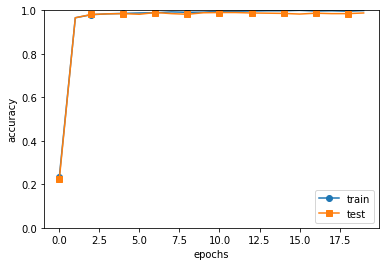

In [21]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

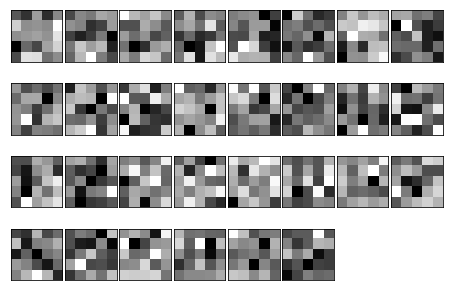

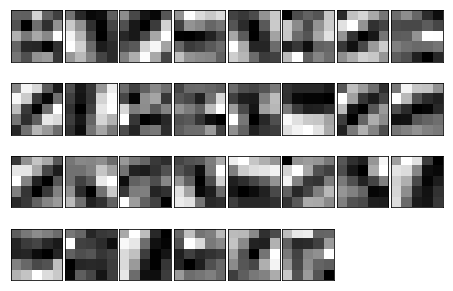

In [24]:
import numpy as np
import matplotlib.pyplot as plt
#from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])